### Import des différents librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold,StratifiedKFold
import math
import csv
import torch

#The model
from sklearn.ensemble import IsolationForest

#For preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter("ignore")

### Pretraitement

In [2]:
class AnomalyDetectionDataLoader:

    def __init__(self, file_path, test_size=0.15, random_state=42):
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.target = None
        self.xtrain = None
        self.xtest = None
        self.ytrain = None
        self.ytest = None
        self.scaler = MinMaxScaler()

    def load_data(self):
        self.data = pd.read_csv(self.file_path)

        self.data.drop_duplicates(keep="last", inplace=True)

        self.target = self.data["Class"]
        self.data = self.data.drop(["Class", "Time"], axis=1)

    def preprocess_data(self):

        data_scaled_array = self.scaler.fit_transform(self.data)
        self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns)

    def split_data(self):

        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

    def get_scaler(self):
        return self.scaler



### Transformation des targets
ypred return un vecteur contenant que de -1 pour des données anormales et 1 pour les données normales alors que les targets des <br>
des données initial contiennet des 0 pour des données normales et 1 pour des données anormales. Il faut donc transformer ce vecteur <br>
en un vecteur contenant des 1 pour des données normales et -1 pour les anomalies

In [3]:
def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1

    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1

    elif isinstance(target,np.ndarray):
        target[target==1]=0
        target[target==-1]=1
    return target

### Visualisation des résultats

In [4]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores_(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df

def draw_anomaly(y_true,score, seuil):
    groupDF=pd.DataFrame({
        "error":score,
        "true":y_true
    }).groupby('true')
    fig, ax=plt.subplots(figsize=(12,8))

    for name, group in groupDF:
        ax.plot(group.index,group.error,marker='x', linestyle='',color='r' if name==1 else 'g',label="anomalie" if name==1 else "normal")
    ax.hlines(seuil,ax.get_xlim()[0],ax.get_xlim()[1], colors ="b", zorder=100,label="Seuil")
    ax.legend()
    
    plt.title("Anomalies")
    plt.xlabel("Données")
    plt.ylabel("Score(erreur)")
    plt.show()

def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    # precision_recall_display(ytrue, ypred)
    # roc_curve_disolay(ytrue, ypred)
    scores_(ytrue,ypred)

### Recherche des hyperparametres :Grid Search Cross-Validation (GridSearchCV)
Notre approche ici es d'implémenter notre propre fonction pour la recherche des hyper paramètres de nos différents modèles.<br> Par exemple les étiquettes de prédiction de notre jeu de données de fraudes banquaires sont 0 pour les transactions normales et 1 pour les transaction frauduleuses.<br> Cependant les étiquettes prédites par l'algorithme de forêt d'isolation (Isoalation Forest) sont -1 et 1. Les étiquettes prédictes et les étiquettes réelles sont différentes. <br>
Pour faire face à ce problème nous avons implémenté deux fonctions, transformed_target et inverse_transforme_target, pour convertir les labels de sorte à avoir les deux labels dans la bonne version. <br>
Cependant lors de la recherche des hyeper paramètres, nous passont nos données une seule fois en argment de la fonction GridSearchCV. Nous ne sommes donc pas à mesure de convertir les labels de prédiction de chaques modèle afin de l'evaluer. Nous avons jugé interessant d'implémenter notre fonction de GridSearchCV de sorte à pouvoir transformer les étiquettes de prédictions de chaque modèle sur un lot de paramètres données afin de pouvoir l'évaluer.

In [5]:
class CustomGridSearchCV:

    def __init__(self, estimator, param_grid, n_splits=5, random_state=42):
        self.estimator = estimator
        self.param_grid = param_grid
        self.n_splits = n_splits
        self.random_state = random_state
        self.best_score = 0
        self.best_params = None
        self.best_estimator = None

    def fit(self, X, y):

        f1_scorer = make_scorer(f1_score)
        param_grid = ParameterGrid(self.param_grid)
        skf=StratifiedKFold(n_splits=self.n_splits, random_state=None, shuffle=False)

        for params in tqdm(param_grid):


            total_score = 0

            # Itérer sur les plis de la validation croisée
            for train_index, val_index in tqdm(skf.split(X,y)):
                xtrain_fold, xval_fold = X.iloc[train_index], X.iloc[val_index]
                ytrain_fold, yval_fold = y.iloc[train_index], y.iloc[val_index]

                # Entraîner le modèle
                model = self.estimator.set_params(**params)
                model.fit(xtrain_fold)

                # Faire des prédictions
                ypred_val = model.predict(xval_fold)
                ypred_val = inverse_transform_target(ypred_val)

                current_score = f1_score(ypred_val, yval_fold)

                total_score += current_score

            avg_score = total_score / self.n_splits

            # Afficher les paramètres et le score moyen
            print("Paramètres:", params)
            print("Score moyen (f1_score):", avg_score)
            print(" ")

            if avg_score > self.best_score:
                self.best_score = avg_score
                self.best_params = params
                self.best_estimator=model

        # Afficher les meilleurs paramètres
        print("Meilleurs paramètres :", self.best_params)
        print("Meilleur score moyen (f1_score) :", self.best_score)
    def predict(self,xtest):
        return self.best_estimator.predict(xtest)

## Expérimentation sur différents jeux de données

### Credit cards fraud detection
Le jeu de données des transaction frauduleuses

In [6]:
# Utilisation de la classe
data_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
# data_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv"
data_loader = AnomalyDetectionDataLoader(file_path=data_path)
data_loader.load_data()
# data_loader.preprocess_data()
data_loader.split_data()

xtrain, ytrain = data_loader.get_train_data()
xtest, ytest = data_loader.get_test_data()
scaler = data_loader.get_scaler()


### Recherche d'hyper-paramètres par la méthode de GridSearchCV

In [7]:
parameters={
    "n_estimators":[300,500,700],
    "contamination":[0.0012, 0.0015,0.0017, 0.0019, 0.0021, 0.0023],
    "max_samples":[0.6,0.8],
    "max_features":[0.6, 0.8]
    
}

best_par={
          'contamination': [0.009],
          'max_features': [0.9],
          'max_samples': [0.8],
          'n_estimators': [300,400,500,600,700,800,900,1000]
}
model=CustomGridSearchCV(estimator=IsolationForest(random_state=42), param_grid=parameters, n_splits=5, random_state=42)
model.fit(xtrain,ytrain)

  0%|          | 0/72 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.28568891828008997
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.27625537413753837
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.2785333973601691
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.28039255758966375
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.27398755332080327
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.27443326348018304
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.27165760126323507
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.2767696530686821
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.27583848663152344
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.27442591717343584
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.2745494639664613
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0012, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.2749199503098047
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.29171459008679623
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.28525709288767975
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.28665103201009423
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.28988790578895507
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.2909232912543058
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.2884563722136785
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.2829683212583671
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.28740823339047816
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.2891492064354984
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.28701479044638684
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.28496776561520987
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0015, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.2826656746036815
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.2925304893960101
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.28934110455970496
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.289246617321171
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.29542459153749473
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.2903122584325263
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.2895791777460099
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.2828966720251736
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.28611313776879
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.2906030615333939
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.2911116773008216
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.2857260535218068
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0017, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.290286461291999
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.30944033817938554
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.3066832532521727
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.3066573247367158
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.30895080085789217
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.3147437353319706
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.31308578146087773
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.29617817913895256
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.29804304703489404
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.30069503297697514
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.301775742179473
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.3000587422184481
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0019, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.30201863754443103
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.31269517626081544
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.3067899535486493
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.3071414692789137
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.3134140645202098
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.31684402579406573
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.31334518914024445
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.2991911071945498
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.30287610539716325
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.3012359960911658
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.30597384516573983
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.3052782889624995
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0021, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.3059752331320399
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.3077067322754074
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.30985830880076115
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.3078204004253665
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.311603366502459
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.3080321722193168
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.3092706971339231
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 300}
Score moyen (f1_score): 0.3006689905888436
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 500}
Score moyen (f1_score): 0.3052387057667597
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.8, 'max_samples': 0.6, 'n_estimators': 700}
Score moyen (f1_score): 0.3072195820115603
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 300}
Score moyen (f1_score): 0.3009525467817932
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 500}
Score moyen (f1_score): 0.31012759869622264
 


0it [00:00, ?it/s]

Paramètres: {'contamination': 0.0023, 'max_features': 0.8, 'max_samples': 0.8, 'n_estimators': 700}
Score moyen (f1_score): 0.3008574338633388
 
Meilleurs paramètres : {'contamination': 0.0021, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 500}
Meilleur score moyen (f1_score) : 0.31684402579406573


In [8]:
params_iforest={'contamination': 0.0021, 'max_features': 0.6, 'max_samples': 0.8, 'n_estimators': 700}
iforest=IsolationForest(**params_iforest)
iforest.fit(xtrain)

IsolationForest(contamination=0.0021, max_features=0.6, max_samples=0.8,
                n_estimators=700)

In [9]:
ypred=iforest.predict(xtest)

In [10]:
ypred=inverse_transform_target(ypred)

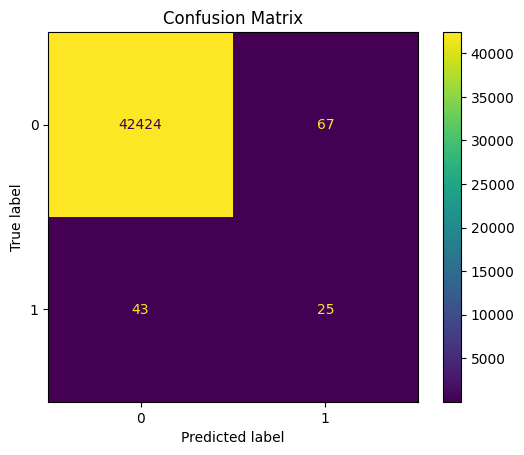

   f1_score  accuracy_score  precision_score  recall_score
0    0.3125        0.997415         0.271739      0.367647


In [11]:
evaluation(ytest,ypred)

### Histogramme de scores d'anomalies

In [12]:
score=-iforest.score_samples(xtest)
score_pd=pd.Series(score)

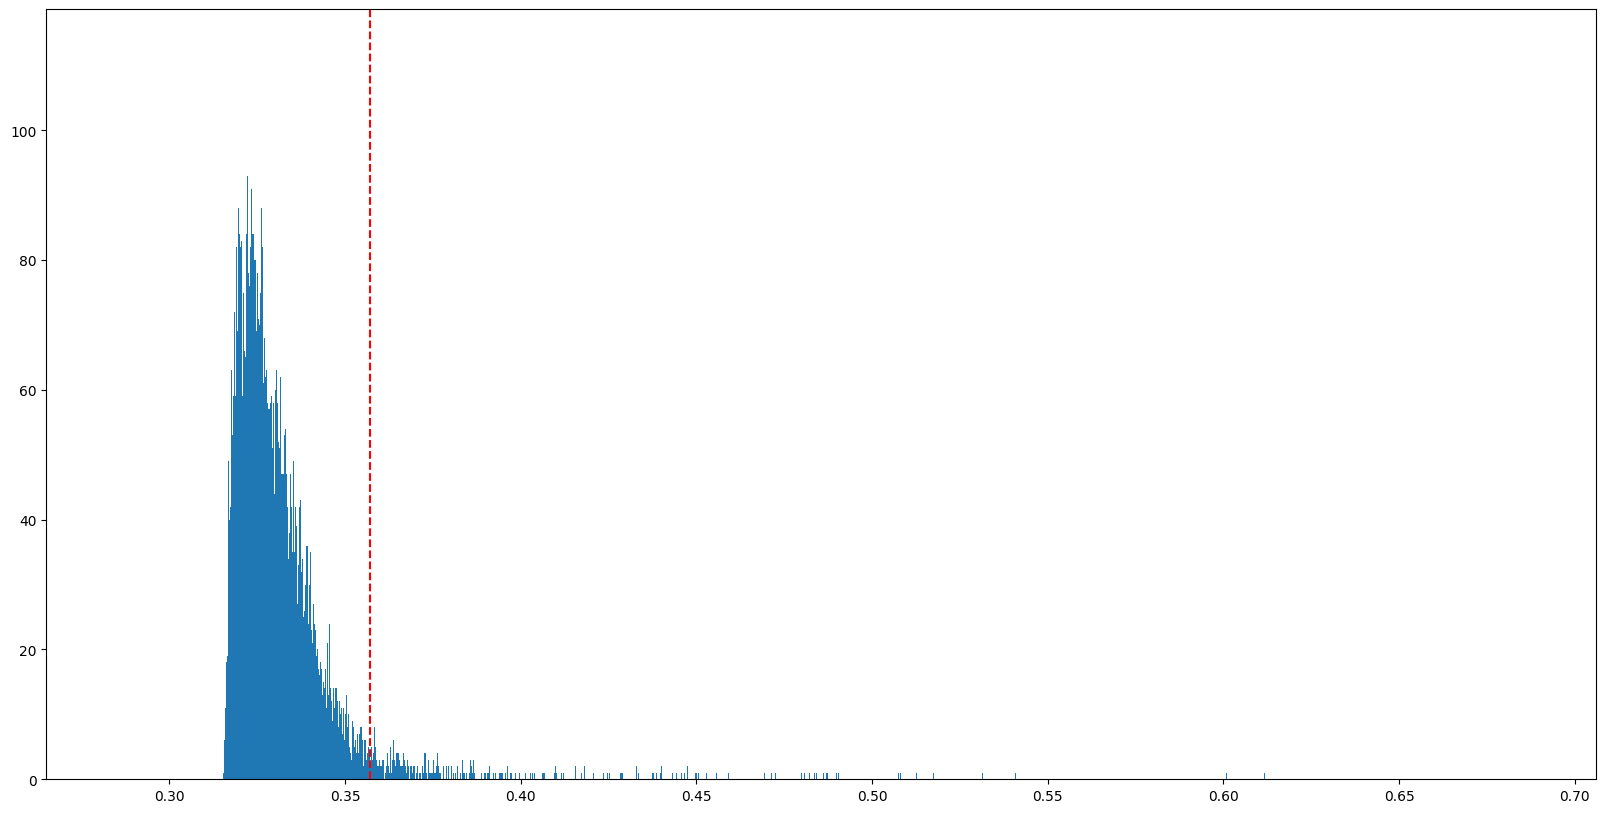

In [13]:
fig,ax=plt.subplots(figsize=(20,10))
plt.xlim(min(score)-0.05, max(score_pd))
score_pd.hist(bins=10000,grid=False)

# Détermination de pourcentage de contamination
q=95
plt.axvline(np.percentile(score_pd, q=q), color='red', linestyle='--', label=f'{q}e percentile')

plt.show()

### Boite à moustache des scores d'anomalies

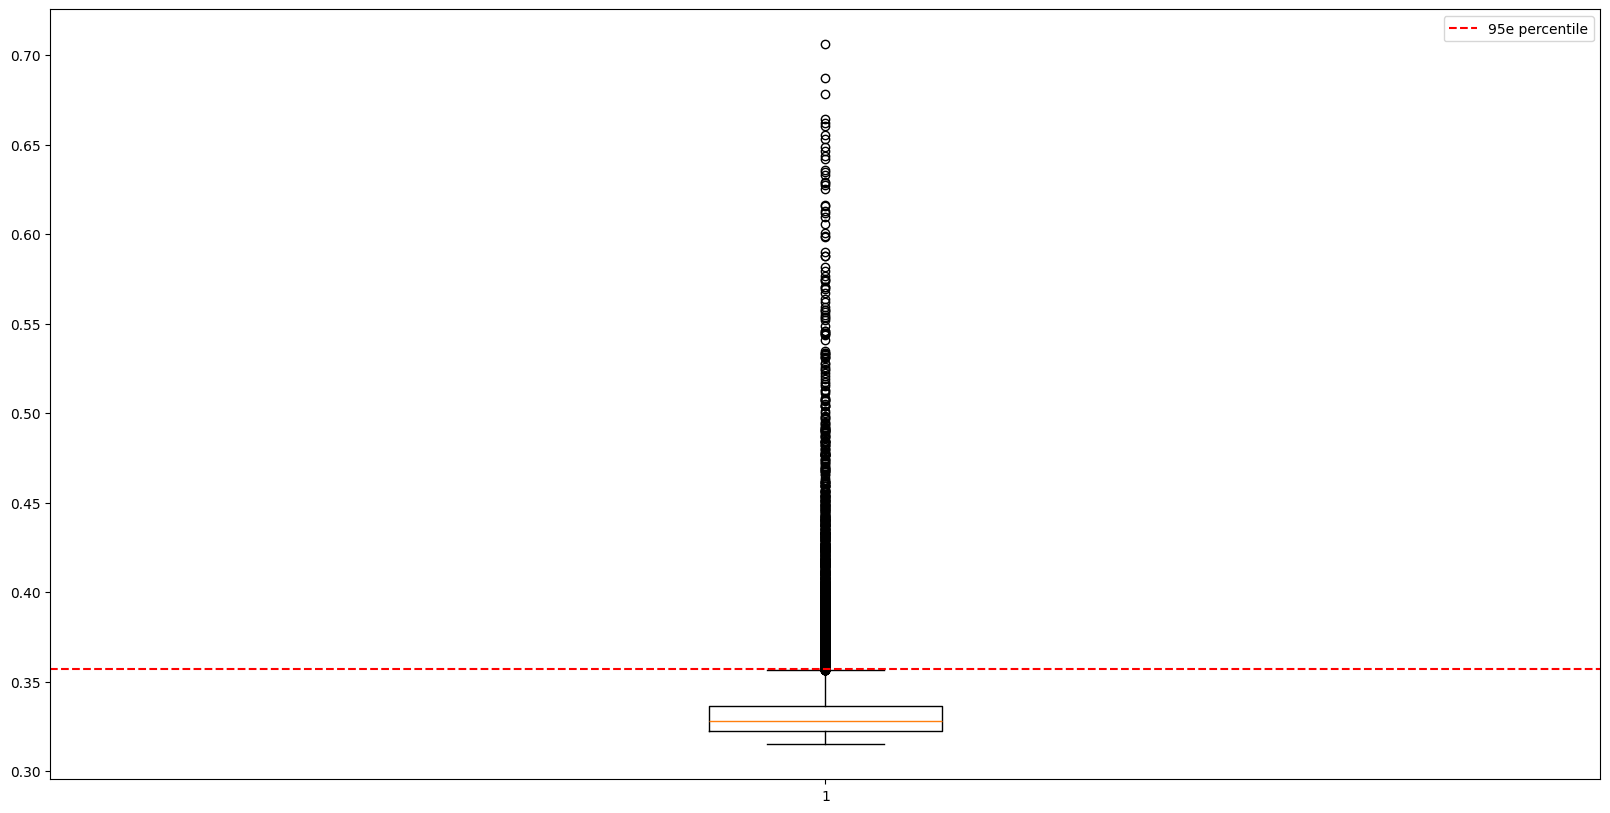

In [14]:
fig,ax=plt.subplots(figsize=(20,10))
# plt.xlim(min(score)-0.2, max(score))
plt.boxplot(score_pd)

# Détermination de pourcentage de contamination
q=95
plt.axhline(np.percentile(score, q=q), color='red', linestyle='--', label=f'{q}e percentile')
plt.legend()

plt.show()


### Visualisation des anomalies


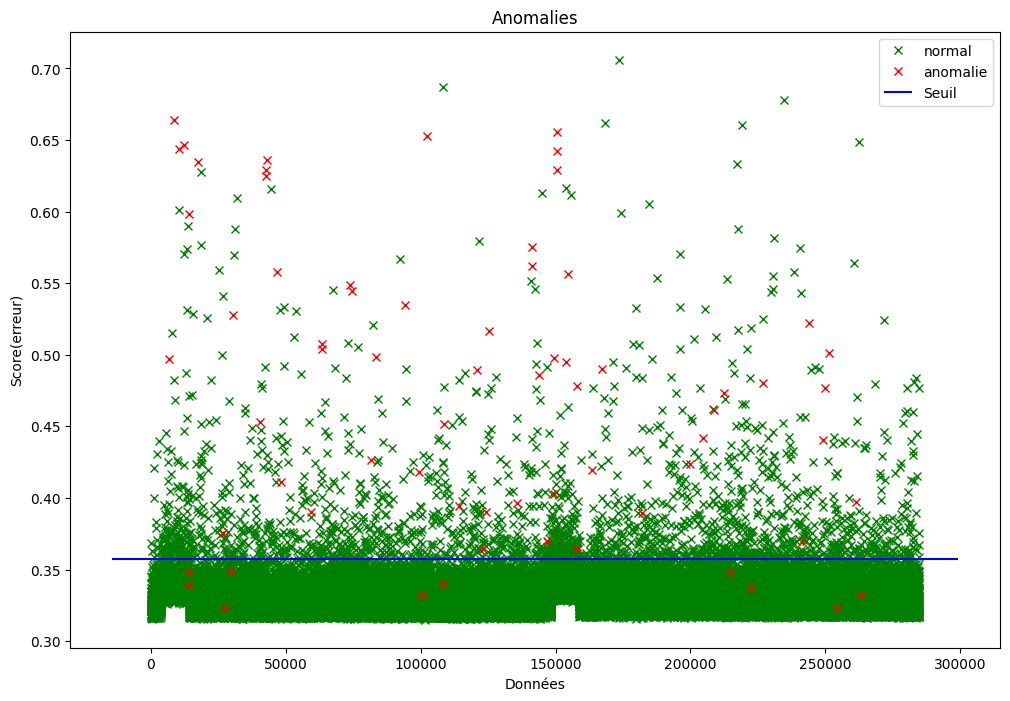

In [15]:
draw_anomaly(y_true=ytest,score=score, seuil=np.percentile(score, q=q))

### Prediction, matrice de confusion et autres metriques

### Sauvegarde des résulatats

In [16]:
file_name="../resultats/isolation_forest.csv"

with open(file_name,"w",newline="") as csvfile:
    writer=csv.DictWriter(csvfile,fieldnames=["y_pred","score_anomalie","y_true"])
    writer.writeheader()
    n=score.shape[0]
    for i in range(n):
        row={
            "y_pred":ypred[i],
            "score_anomalie":score[i],
            "y_true":ytest.iloc[i],
        }
        writer.writerow(row)

### Courbes ROC-AUC

Isolation: ROC AUC=0.951


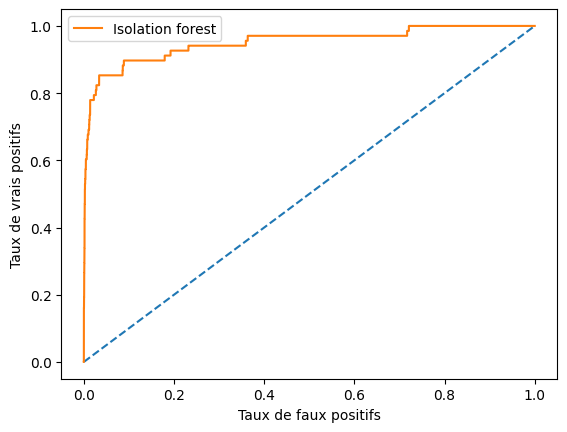

In [17]:

ns_probs = [0 for _ in range(len(ytest))]
# keep probabilities for the positive outcome only
np_score = score.tolist()
tensor=torch.tensor([np_score])
lr_probs = torch.softmax(tensor,dim=1,dtype=torch.float32).squeeze(0).numpy()

# calculate scores
ns_auc = roc_auc_score(ytest, ns_probs)
lr_auc = roc_auc_score(ytest, lr_probs)
# summarize scores

print('Isolation: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(ytest, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, linestyle='-', label='Isolation forest')
# axis labels
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
# show the legend
plt.legend()
# show the plot
plt.show()

TSNE VISUALISATION

In [18]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['Class', 'Time'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv'

In [ ]:
viz_y = iforest.predict(df)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [ ]:
import pickle

In [ ]:
with open("/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src/X_embedded_creditcard.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [ ]:
with open("/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src/embedded_index_creditcard.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Isolation Forest')

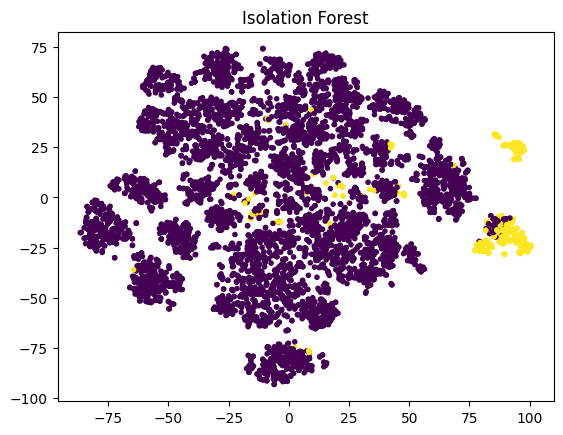

In [ ]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Isolation Forest")